In [2]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ALPUB_PATH = '../../Datasets/alpub_v2/images'

In [4]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [5]:
Y.shape

(205797, 24)

In [6]:
X.shape

(205797, 70, 70, 3)

In [7]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

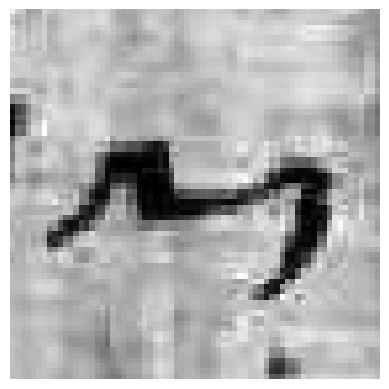

In [8]:
# Display the grayscale image
plt.imshow(X_gray[100000], cmap="gray")
plt.axis("off")
plt.show()

In [204]:
X_in = np.array(X_gray)
X_in = X_in.reshape([205797,1, 70, 70])
X_in.shape

(205797, 1, 70, 70)

In [205]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y, test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

In [206]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Test images shape:",X_test.shape)
print("Test labels shape:",Y_test.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (166695, 1, 70, 70)
Train labels shape: (166695, 24)
Test images shape: (20580, 1, 70, 70)
Test labels shape: (20580, 24)
Validation images shape: (18522, 1, 70, 70)
Validation labels shape: (18522, 24)


In [207]:
#ConvAutoencoder Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset

In [208]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [209]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [210]:
train_dataset = CharacterDataset(X_train, Y_train)
test_dataset = CharacterDataset(X_test, Y_test)
val_dataset = CharacterDataset(X_val, Y_val)

In [221]:
#Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        # Define the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.bottleneck = nn.Sequential(
            nn.Linear(128*5*5, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 128*5*5),
            nn.ReLU()
        )
        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.bottleneck(x)
        #print(x.size())
        x= x.view(x.size(0),128, 5, 5)
        #print(x.size())
        x = self.decoder(x)
        #print(x.size())
        x = x[:,:,:70, :70] # the output of decoder would be 72x72 trimming it to 70x70
        #print(x.size())
        return x

Epoch [1/10], Train Loss: 1610.7119, Test Loss: 1495.4781
Epoch [2/10], Train Loss: 1504.4792, Test Loss: 1492.6439
Epoch [3/10], Train Loss: 1499.5608, Test Loss: 1485.7577
Epoch [4/10], Train Loss: 1496.9207, Test Loss: 1485.5392
Epoch [5/10], Train Loss: 1106.2346, Test Loss: 978.9730
Epoch [6/10], Train Loss: 987.6222, Test Loss: 975.7074
Epoch [7/10], Train Loss: 985.8612, Test Loss: 973.3975
Epoch [8/10], Train Loss: 984.4619, Test Loss: 976.0692
Epoch [9/10], Train Loss: 983.1006, Test Loss: 971.1031
Epoch [10/10], Train Loss: 981.9601, Test Loss: 969.7996


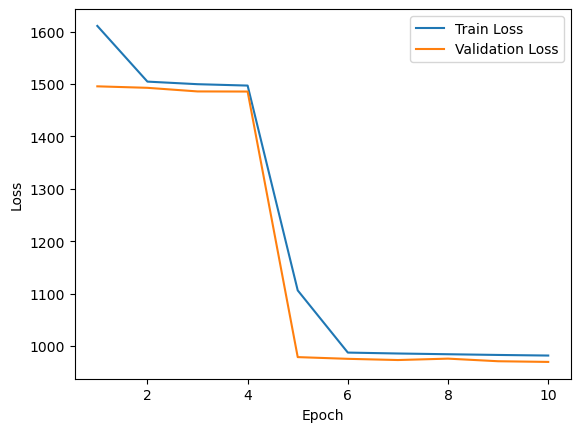

In [222]:
#for latent_dim in [2,5,10,25,50,100,500]: # evaluate for [2,5,10,25,50,100,500] latent dims

latent_dim = 2
batch_size = 64

model = ConvAutoencoder(latent_dim)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

best_test_loss = float('inf')
best_model_state = None

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()
    for batch in train_loader:
        images, labels = batch

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)
torch.save(model, '../models/alpub_conv_autoencoder.pt')

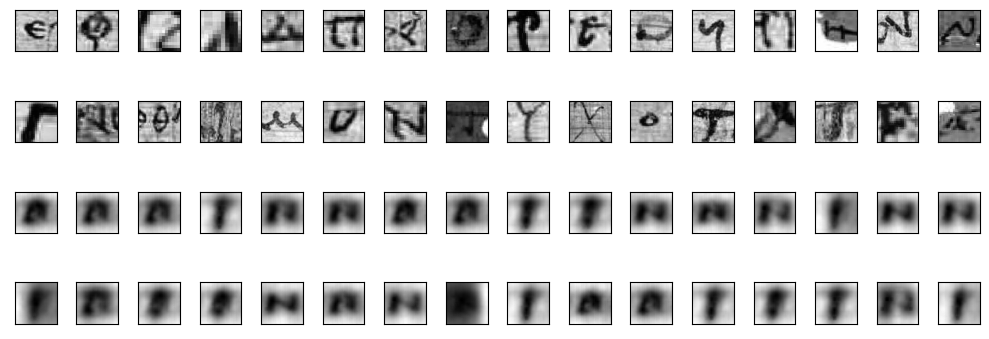

In [223]:
model = torch.load('../models/alpub_conv_autoencoder.pt')
# Set the model to evaluation mode
model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Get a batch of test data
test_batch = next(iter(test_loader))
test_images, _ = test_batch

# Pass the test data through the model
with torch.no_grad():
    reconstructions = model(test_images)

# Plot the original images and their reconstructions
fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < batch_size // 2:
        # Plot original image
        ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        # Plot reconstructed image
        ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])


plt.tight_layout()
plt.show()